In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

In [2]:
import seaborn as sns

In [3]:
# DATA IS FROM https://www.kaggle.com/austinreese/craigslist-carstrucks-data version 8. 
vehicles = pd.read_csv('../Raw Data/vehicles_v8.csv')

<AxesSubplot:>

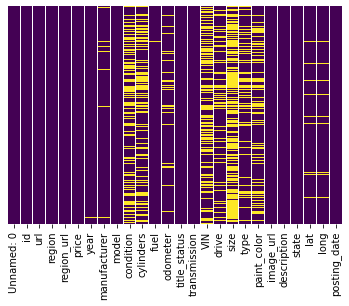

In [4]:
# CHECK FOR MISSING DATA:
sns.heatmap(vehicles.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [5]:
pd.set_option('display.max_columns', None)
vehicles

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,NaN,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,NaN,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458208,458208,7240959076,https://wausau.craigslist.org/ctd/d/wisconsin-...,wausau,https://wausau.craigslist.org,14995,2014.0,cadillac,srx,excellent,6 cylinders,gas,83790.0,clean,automatic,NaN,4wd,mid-size,SUV,silver,https://images.craigslist.org/00808_1bVcaYZtCy...,2014 Cadillac SRX All Wheel Drive Luxury Colle...,wi,44.408867,-89.881210,2020-12-03T08:56:29-0600
458209,458209,7240954682,https://wausau.craigslist.org/ctd/d/wisconsin-...,wausau,https://wausau.craigslist.org,17895,2018.0,hyundai,tucson,excellent,4 cylinders,gas,31888.0,clean,automatic,NaN,4wd,mid-size,SUV,white,https://images.craigslist.org/00l0l_gikkP11dEF...,2018 Hyundai Tucson SE 2.0 I4 AWD. Carfax ver...,wi,44.408867,-89.882240,2020-12-03T08:48:08-0600
458210,458210,7240645700,https://wyoming.craigslist.org/cto/d/sheridan-...,wyoming,https://wyoming.craigslist.org,17900,2014.0,cadillac,cts coupe awd,excellent,6 cylinders,gas,53000.0,clean,automatic,NaN,4wd,mid-size,coupe,black,https://images.craigslist.org/00t0t_lNnW4cboOG...,"53,000 miles. Cosmetically, in near mint condi...",wy,44.784900,-106.964800,2020-12-02T14:09:45-0700
458211,458211,7240600465,https://wyoming.craigslist.org/cto/d/sheridan-...,wyoming,https://wyoming.craigslist.org,1300,2008.0,jeep,grand cherokee,good,8 cylinders,gas,164000.0,clean,automatic,1J8HR48N78C242593,4wd,mid-size,SUV,white,https://images.craigslist.org/00C0C_fl0NW1IeJw...,PRICE REDUCTION Turns out the engine is toast...,wy,44.773500,-106.939600,2020-12-02T13:01:04-0700


In [6]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    458213 non-null  int64  
 1   id            458213 non-null  int64  
 2   url           458213 non-null  object 
 3   region        458213 non-null  object 
 4   region_url    458213 non-null  object 
 5   price         458213 non-null  int64  
 6   year          457163 non-null  float64
 7   manufacturer  439993 non-null  object 
 8   model         453367 non-null  object 
 9   condition     265273 non-null  object 
 10  cylinders     287073 non-null  object 
 11  fuel          454976 non-null  object 
 12  odometer      402910 non-null  float64
 13  title_status  455636 non-null  object 
 14  transmission  455771 non-null  object 
 15  VIN           270664 non-null  object 
 16  drive         324025 non-null  object 
 17  size          136865 non-null  object 
 18  type

In [8]:
# DATA FROM https://www.fueleconomy.gov/feg/ws/index.shtml
# THIS DATA WILL BE USED TO FILL IN MISSING CYLINDERS, DRIVE, SIZE, AND TYPE VALUES
epa_vehicles = pd.read_csv('../Raw Data/EPA_Cars_1984-2022.csv')

C:\Users\George\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<AxesSubplot:>

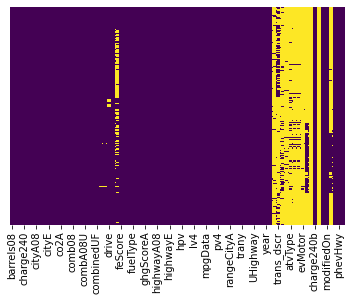

In [9]:
# CHECK FOR MISSING DATA:
sns.heatmap(epa_vehicles.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [10]:
epa_vehicles

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
0,15.695714,0.0,0,0.0,19,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,423.190476,21,0.0,0,0.0,0.0,0.0,0.0,4.0,2.0,Rear-Wheel Drive,9011,(FFS),-1,1950,0,Regular,Regular Gasoline,-1,-1,25,0.0,0,0.0,0.0,0.0,0.0,0,0,1,0,0,Alfa Romeo,Spider Veloce 2000,Y,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,23.3333,0.0,35.0000,0.0,Two Seaters,1985,-2250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
1,29.964545,0.0,0,0.0,9,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,12.0,4.9,Rear-Wheel Drive,22020,(GUZZLER),-1,3700,0,Regular,Regular Gasoline,-1,-1,14,0.0,0,0.0,0.0,0.0,0.0,0,0,10,0,0,Ferrari,Testarossa,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,11.0000,0.0,19.0000,0.0,Two Seaters,1985,-11000,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
2,12.207778,0.0,0,0.0,23,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,329.148148,27,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,Front-Wheel Drive,2100,(FFS),-1,1500,0,Regular,Regular Gasoline,-1,-1,33,0.0,0,0.0,0.0,0.0,0.0,19,77,100,0,0,Dodge,Charger,Y,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,29.0000,0.0,47.0000,0.0,Subcompact Cars,1985,0,NaN,SIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
3,29.964545,0.0,0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,8.0,5.2,Rear-Wheel Drive,2850,NaN,-1,3700,0,Regular,Regular Gasoline,-1,-1,12,0.0,0,0.0,0.0,0.0,0.0,0,0,1000,0,0,Dodge,B150/B250 Wagon 2WD,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 3-spd,12.2222,0.0,16.6667,0.0,Vans,1985,-11000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
4,17.347895,0.0,0,0.0,17,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,467.736842,19,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,66031,"(FFS,TRBO)",-1,2650,0,Premium,Premium Gasoline,-1,-1,23,0.0,0,0.0,0.0,0.0,0.0,0,0,10000,0,14,Subaru,Legacy AWD Turbo,N,False,0,90,0,0.0,0.0,0.0,0.0,Manual 5-spd,21.0000,0.0,32.0000,0.0,Compact Cars,1993,-5750,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43354,14.982273,0.0,0,0.0,19,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,403.954545,22,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,Front-Wheel Drive,66030,(FFS),-1,1850,0,Regular,Regular Gasoline,-1,-1,26,0.0,0,0.0,0.0,0.0,0.0,0,0,9995,0,14,Subaru,Legacy,N,False,0,90,0,0.0,0.0,0.0,0.0,Automatic 4-spd,24.0000,0.0,37.0000,0.0,Compact Cars,1993,-1750,NaN,CLKUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
43355,14.330870,0.0,0,0.0,20,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,386.391304,23,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,Front-Wheel Drive,66030,(FFS),-1,1750,0,Regular,Regular Gasoline,-1,-1,28,0.0,0,0.0,0.0,0.0,0.0,0,0,9996,0,14,Subaru,Legacy,N,False,0,90,0,0.0,0.0,0.0,0.0,Manual 5-spd,25.0000,0.0,39.0000,0.0,Compact Cars,1993,-12

In [10]:
epa_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43359 entries, 0 to 43358
Data columns (total 83 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   barrels08        43359 non-null  float64
 1   barrelsA08       43359 non-null  float64
 2   charge120        43359 non-null  int64  
 3   charge240        43359 non-null  float64
 4   city08           43359 non-null  int64  
 5   city08U          43359 non-null  float64
 6   cityA08          43359 non-null  int64  
 7   cityA08U         43359 non-null  float64
 8   cityCD           43359 non-null  float64
 9   cityE            43359 non-null  float64
 10  cityUF           43359 non-null  float64
 11  co2              43359 non-null  int64  
 12  co2A             43359 non-null  int64  
 13  co2TailpipeAGpm  43359 non-null  float64
 14  co2TailpipeGpm   43359 non-null  float64
 15  comb08           43359 non-null  int64  
 16  comb08U          43359 non-null  float64
 17  combA08     